In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#for KAN Model
import kan
from sklearn.model_selection import TimeSeriesSplit
import torch

#Network Analysis and Clustering
from scipy.spatial import distance
import networkx as nx

#Stationarity Testing
import statsmodels as sm

#GLASSO
from sklearn import covariance, preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Dcov
import dcor

#Louvain algorithm
import community

#Progress bar
import sys
def drawProgressBar(percent, barLen = 20):
    sys.stdout.write("\r")
    progress = ""
    for i in range(barLen):
        if i < int(barLen * percent):
            progress += "="
        else:
            progress += " "
    sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
    sys.stdout.flush()

In [3]:
NetworkDf = pd.read_csv('../NetworkDataSets/CellCounts2015_2020.csv').drop(['Unnamed: 0', 'Observation Date'], axis = 1)

NetworkDf[NetworkDf.select_dtypes(include=['number', 'object']).columns] = NetworkDf.select_dtypes(include=['number', 'object']).astype(float)



In [4]:
NetworkDf = NetworkDf.groupby(['Cell', "TimeStamp"]).size().reset_index(name='n').pivot(index = 'TimeStamp', columns = "Cell", values = "n").fillna(value = 0)

NetworkDf.head()

Cell,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,552.0,553.0,554.0,555.0,556.0,557.0,558.0,559.0,560.0,561.0
TimeStamp,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,1.0,1.0,4.0,1.0,11.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,2.0,0.0,15.0,4.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,6.0,7.0,2.0,15.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Seasonality fixing!!!
res = sm.tsa.seasonal.seasonal_decompose(NetworkDf)

In [5]:
ProportionDf = NetworkDf
ProportionDf['Sum'] = ProportionDf.apply(np.sum, axis = 1)
ProportionDf = ProportionDf.apply(lambda o: o / o.Sum, axis = 1)
ProportionDf = ProportionDf.drop("Sum", axis = 1)

Corr_Matrix = NetworkDf.corr()
Proportion_Corr_Matrix = ProportionDf.corr()
Proportion_Cov_Matrix = ProportionDf.cov()
RollingDf = ProportionDf.rolling(3).sum().dropna()


In [6]:
X = RollingDf.iloc[:-1,:]
Y = RollingDf.iloc[1:, :]
tss = TimeSeriesSplit(n_splits = 5)

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    Y_train, Y_test = Y.iloc[train_index, :], Y.iloc[test_index, :]
print(X_train.shape)
print(Y_train.shape)

(1315, 788)
(1315, 788)


In [7]:
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train.to_numpy())
dataset['train_label'] = torch.from_numpy(Y_train.to_numpy())
dataset['test_input'] = torch.from_numpy(X_test.to_numpy())
dataset['test_label'] = torch.from_numpy(Y_test.to_numpy())

In [ ]:

#Run when I gts
KANModel = kan.KAN(width = [NetworkDf.shape[1]-1, 5, NetworkDf.shape[1]-1], grid = 3, k=3, seed = 0)
history = KANModel.train(dataset, steps=20)

plt.plot(history['train_loss'], color = "green")
plt.plot(history['test_loss'], color = 'red')

KANModel.save_ckpt('KAN_20Steps.ckpt')

In [17]:
#Distance Correlation Edges and Eigvenvectors
def Distance_Correlation(M):
    final = np.zeros((M.shape[1], M.shape[1]))
    for row_index, i in enumerate(np.transpose(M)):
        for col_index, j in enumerate(np.transpose(M)):
            if col_index > row_index:
                val = distance.correlation(i,j)
                final[row_index, col_index] = val
                final[col_index,row_index] = val
        final[row_index, row_index] = 0
    return final


g = nx.Graph()
g.add_nodes_from([i for i in range(len(Proportion_Cov_Matrix))])
#Create random permutations of columns and test for significance
Prop_Matrix = ProportionDf.to_numpy()
nrows = Prop_Matrix.shape[0]
ncols = Prop_Matrix.shape[1]
rows = np.arange(nrows)
all_matrices = np.zeros(shape = (ncols, ncols, 50))
for i in range(49):
    #Create a copy of the matrix
    copy = Prop_Matrix
    for col in range(ncols):
        #Create random Permutations of each column
        np.random.shuffle(rows)
        copy[:, col] = copy[rows, col] 
    all_matrices[:,:,i+1] = Distance_Correlation(copy)
    drawProgressBar(i+1/50)
all_matrices[:,:,0] = Distance_Correlation(Prop_Matrix)
drawProgressBar(1)

[ ===================  ] 96.00%

In [ ]:
+#Perform Significance Tests for covariance
delta = 0.005 #Personal Choice for delta to be significant
for row in range(ncols):
    for col in range(ncols):
        for mat in range(50):
            val = all_matrices[row,col,mat]

In [ ]:
np.cov(np.transpose(Prop_Matrix))[1.:]

Note that in 2016 (?) there was a paper published by Huo and Szekely titled "fast computing for distance covariance", which describes an algorithm for an U-statistic for Distance Covarariance that can be calculated in $O(n log (n))$ as opposed to the original (and current) implementation of $O(n^2)$. This has not been implemented here yet, but if I have the time I intend to as it should make this significantly faster. Otherwise, I think the only place for speedup would be to run this with a compiler language like C.

In [127]:
#Distance Covariance Edges
class DimensionError(Exception):
    pass
'''

'''
def dcov(x: list, y: list, metric = "euclid"):
    if len(x) != len(y):    raise DimensionError("Samples must have the same size")

    #Create distance matrices
    Dx = distance_matrix(x, "x", metric)
    Dy = distance_matrix(y, "y", metric)
    #Double center both matrices

    Dx = double_centered(Dx)
    Dy = double_centered(Dy)

    #Calculate dcov
    dcov = np.sum(Dx * Dy) / (len(x)**2)
    return np.sqrt(dcov)
def double_centered(M: np.array):
    #M is a metric distance array,
    #Diagonals are 0, M is symmetric, all entries non-negative

    #A double centered matrix follows the formula, a_ij = a^0_ij - \bar{a_j} - \bar{a_i} + \bar{a}
    row_means = M.mean(axis=1)
    col_means = M.mean(axis=0)
    total_mean = M.mean()

    M_centered = M - row_means[:, np.newaxis] - col_means[np.newaxis, :] + total_mean
    return M_centered
def EDM(a: np.array, b: np.array):
    if a.ndim == 1:
        return np.sqrt(((a[:, np.newaxis] - b[np.newaxis, :]))**2)
    p1 = np.sum(a**2, axis = 1)[:, np.newaxis]
    p2 = np.sum(b**2, axis = 1)
    p3 = -2 * np.dot(a, b.T)
    return np.sqrt(p1+p2+p3)

def distance_matrix(vec: list, name: str, metric = "euclid"):
    metrics = {"euclid": EDM}
    
    return metrics[metric](vec, vec)

def dCovMat(matrix, max_s = 0):
    if max_s == 0:  max_s = matrix.shape[0]
    DcovMat = np.zeros((matrix.shape[1], matrix.shape[1]))
    for i in range(DcovMat.shape[0]):
        for j in range(i, DcovMat.shape[0]):
            DcovMat[i,j] = dcov(matrix[:max_s, i], matrix[:max_s, j])
            DcovMat[j,i] = DcovMat[i,j]
        drawProgressBar((i*DcovMat.shape[0]+j)/(DcovMat.shape[0]*DcovMat.shape[0]))
    return DcovMat

dcovmat = dCovMat(PropArray, 730)
 

[ ===================  ] 100.00%

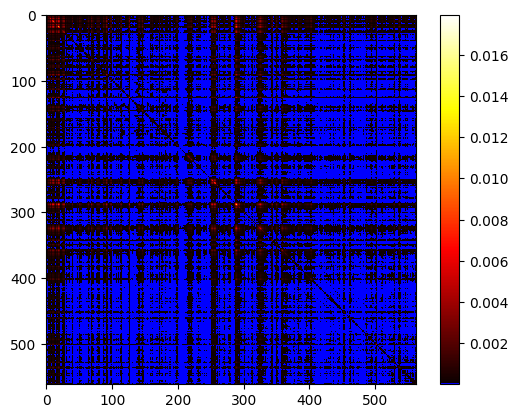

In [146]:

cmap = plt.get_cmap('hot')
newcolors = cmap(np.linspace(0, 1, 256))
blue = np.array([0, 0, 1, 1]) #0 values bc it may not be exactly 0, since it should be impossible, buttttt it does leave 

newcolors[0, :] = blue
custom_cmap = ListedColormap(newcolors)
plt.imshow(dcovmat, cmap = custom_cmap)
plt.colorbar()
plt.show()

In [62]:

X = NetworkDf.values.astype('float64')
myScaler = preprocessing.StandardScaler()
X = myScaler.fit_transform(X)
emp_cov = covariance.empirical_covariance(X)
shrunk_cov = covariance.shrunk_covariance(emp_cov, shrinkage=0.82) # Set shrinkage closer to 1 for poorly-conditioned data

alphaRange = 10.0 ** np.arange(-8,0) # 1e-7 to 1e-1 by order of magnitude
for alpha in alphaRange:
    try: 
        graphCov = covariance.graphical_lasso(shrunk_cov, alpha)
        print(f"Calculated graph-lasso covariance matrix for alpha={alpha}")
    except FloatingPointError:
        print(f"Failed at alpha={alpha}")


c:\Users\bobby\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012403587794607152, tolerance: 8.857429886198236e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
c:\Users\bobby\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017719701861751425, tolerance: 9.99019781363006e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
c:\Users\bobby\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_graph_lasso.py:131: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001068104409357451, tolerance: 7.165406973021905e-05
  coefs, _, _, _ = cd_fast.enet_coor

Calculated graph-lasso covariance matrix for alpha=1e-08
Calculated graph-lasso covariance matrix for alpha=1e-07
Calculated graph-lasso covariance matrix for alpha=1e-06
Calculated graph-lasso covariance matrix for alpha=1e-05
Calculated graph-lasso covariance matrix for alpha=0.0001
Calculated graph-lasso covariance matrix for alpha=0.001
Calculated graph-lasso covariance matrix for alpha=0.01
Calculated graph-lasso covariance matrix for alpha=0.1


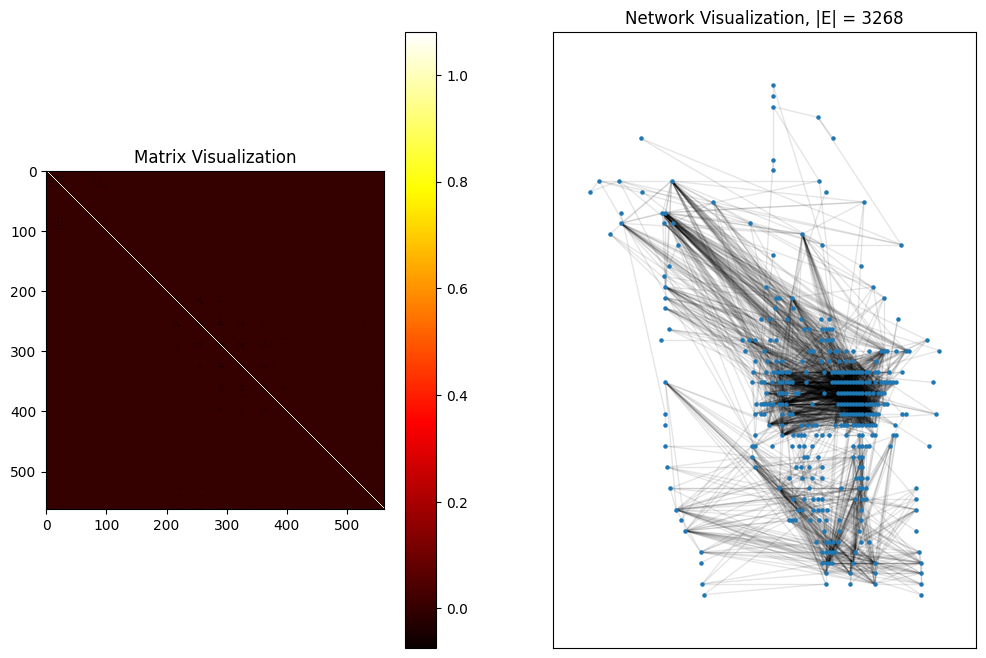

In [64]:
graphCov = covariance.graphical_lasso(shrunk_cov, 0.05) # The higher alpha is, the less edges

#Covariance Plotting
fig, axs = plt.subplots(1,2, figsize = (12,8))
im1 = axs[0].imshow(graphCov[1], cmap = 'hot', interpolation='nearest')
fig.colorbar(im1)
axs[0].set_title("Matrix Visualization")

#Network Visualization
Cells = pd.read_csv('../NetworkDataSets/Cells2015_2020.csv').drop('Unnamed: 0', axis = 1)
def check_touching_cells(cell, cell_list):
    cell_list = cell_list[cell_list['id'] != cell[6]]
    edges = []
    for index, cell2 in cell_list.iterrows():
        if cell2[1] == cell[1] and cell2[0] + cell2[2] == cell[0]: 
                #If they are in the same row, and touch horisontally
                edges.append([cell[6], cell2[6]])
        elif cell2[1] + cell2[3] == cell[1]:
            if cell2[0] >= cell[0] and cell2[0] <= cell[0] + cell[2]:
                #If cell2 touches cell from the bottom and cell2 starts in the middle of cell
                edges.append([cell[6], cell2[6]])
            elif cell2[0] + cell2[2] >= cell[0] and cell2[0] + cell2[2]  <= cell[0] + cell[2]:
                edges.append([cell[6], cell2[6]])
            elif cell2[0] <= cell[0] and cell2[0] <= cell[0] + cell[2] and cell2[0] + cell2[2] >= cell[0] and cell2[0] + cell2[2] >= cell[0] + cell[2]:
                edges.append([cell[6], cell2[6]])
    
    return edges
pos = {}
for index, cell in Cells.iterrows():
    pos[cell[6]] = ((2*cell[0] + cell[2])/2, (cell[1]))
    
edges = []
in_use_nodes = set()
for i in range(ProportionDf.shape[1]):
    for j in range(ProportionDf.shape[1]):
        if abs(graphCov[1][i,j]) > 0 and i < j:
            edges.append([i,j])
            in_use_nodes.add(i)
        else:
            pass
plt.sca(axs[1])
g = nx.Graph()
g.add_nodes_from(in_use_nodes)
g.add_edges_from(edges)

nx.draw_networkx_nodes(g, pos, node_size=5)
nx.draw_networkx_edges(g, pos, alpha=0.1)
axs[1].set_title(f"Network Visualization, |E| = {len(edges)}")
plt.show()

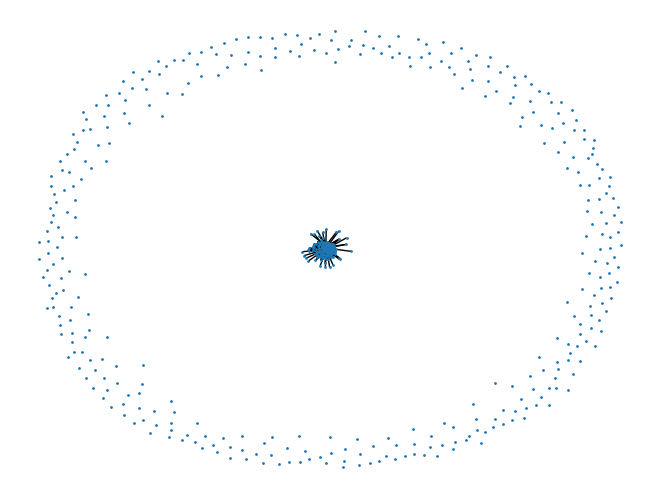

In [140]:

edges = []
for i in range(dcovmat.shape[0]):
    for j in range(dcovmat.shape[0]):
        if dcovmat[i,j] > (10**-3) and i != j: #this is an arbitrary value, the exact value can probably be foud with permutation testing? for size n?
            edges.append([i,j])
        else:
            pass

g = nx.Graph()
g.add_nodes_from([i for i in range(ProportionDf.shape[1])])
g.add_edges_from(edges)

nx.draw(g, node_size = 1)

In [20]:
#Lagged Glasso modeling
def Lagged_Matrix(lag, mat):

    new = np.zeros((mat.shape[0] - lag, mat.shape[1]), dtype=object)

    for i in range(new.shape[0]):
        for j in range(new.shape[1]):
            new[i,j] = [mat[i,j], mat[i+lag,j]]
    return new

Lagged = Lagged_Matrix(5, PropArray)

Number of Communities = 371


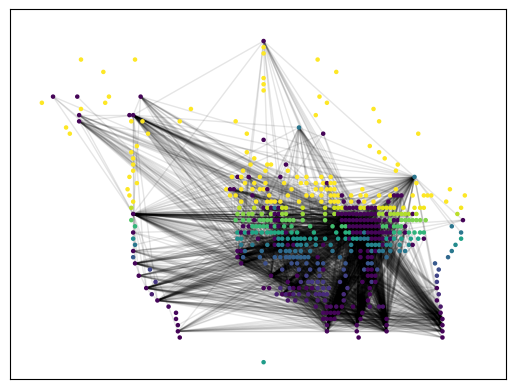

In [143]:
#Community detectino and coloring with louvain algorithm, useful for detecting migration routes maybe?
partition = community.best_partition(g, random_state = 26)

cmap = plt.get_cmap('viridis')
colors = [cmap(partition[node]) for node in g.nodes()]

nx.draw_networkx_nodes(g, pos, node_color=colors, node_size=5, cmap=cmap)
nx.draw_networkx_edges(g, pos, alpha=0.1)
print(f"Number of Communities = {max(partition.values())}")
plt.show()

In [83]:
vec = [1,2,3]
vec = np.array(vec)
np.sqrt(((vec[:, np.newaxis] - vec[np.newaxis, :]))**2)

array([[0., 1., 2.],
       [1., 0., 1.],
       [2., 1., 0.]])

In [144]:
print(len(edges)/2)

3310.0
